In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import bambi as bmb
import arviz as az
from arviz.plots.plot_utils import xarray_var_iter
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import ast

%matplotlib inline

RANDOM_SEED = 42

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
spotify_data = pd.read_csv('spotify_dataset.csv')

In [3]:
spotify_data.head()

Index  Highest Charting Position  Number of Times Charted  \
0      1                          1                        8   
1      2                          2                        3   
2      3                          1                       11   
3      4                          3                        5   
4      5                          5                        1   

  Week of Highest Charting                          Song Name     Streams  \
0   2021-07-23--2021-07-30                            Beggin'  48,633,449   
1   2021-07-23--2021-07-30          STAY (with Justin Bieber)  47,248,719   
2   2021-06-25--2021-07-02                           good 4 u  40,162,559   
3   2021-07-02--2021-07-09                         Bad Habits  37,799,456   
4   2021-07-23--2021-07-30  INDUSTRY BABY (feat. Jack Harlow)  33,948,454   

           Artist Artist Followers                 Song ID  \
0        Måneskin          3377762  3Wrjm47oTz2sjIgck11l5e   
1   The Kid LAROI          2230022  5HCyWlXZPP0y6Gqq8TgA20   
2  Olivia Rodrigo          6266514  4ZtFanR9U6ndgddUvNcjcG   
3      Ed Sheeran         83293380  6PQ88X9TkUIAUIZJHW2upE   
4       Lil Nas X          5473565  27NovPIUIRrOZoCHxABJwK   

                                    Genre  ... Danceability Energy Loudness  \
0  ['indie rock italiano', 'italian pop']  ...        0.714    0.8   -4.808   
1                  ['australian hip hop']  ...        0.591  0.764   -5.484   
2                                 ['pop']  ...        0.563  0.664   -5.044   
3                       ['pop', 'uk pop']  ...        0.808  0.897   -3.712   
4           ['lgbtq+ hip hop', 'pop rap']  ...        0.736  0.704   -7.409   

  Speechiness Acousticness Liveness    Tempo Duration (ms) Valence  Chord  
0      0.0504        0.127    0.359  134.002        211560   0.589      B  
1      0.0483       0.0383    0.103  169.928        141806   0.478  C#/Db  
2       0.154        0.335   0.0849  166.928        178147   0.688      A  
3      0.0348       0.0469    0.364  126.026        231041   0.591      B  
4      0.0615       0.0203   0.0501  149.995        212000   0.894  D#/Eb  

[5 rows x 23 columns]

In [4]:
spotify_data.dtypes

Index                         int64
Highest Charting Position     int64
Number of Times Charted       int64
Week of Highest Charting     object
Song Name                    object
Streams                      object
Artist                       object
Artist Followers             object
Song ID                      object
Genre                        object
Release Date                 object
Weeks Charted                object
Popularity                   object
Danceability                 object
Energy                       object
Loudness                     object
Speechiness                  object
Acousticness                 object
Liveness                     object
Tempo                        object
Duration (ms)                object
Valence                      object
Chord                        object
dtype: object

In [5]:
spotify_data['Release Date'] = pd.to_datetime(spotify_data['Release Date'], format='%Y-%m-%d', errors='coerce')
spotify_data['Release Month'] = spotify_data['Release Date'].dt.month
spotify_data['Genre'] = np.where(spotify_data['Genre']==' ', '[]', spotify_data['Genre'])
spotify_data['Genre'] = spotify_data['Genre'].apply(lambda x: ast.literal_eval(x))
spotify_data = spotify_data.rename(columns={'Duration (ms)':'Duration', 'Artist Followers':'Followers'})
spotify_data = spotify_data.drop(columns='Index')
spotify_data = spotify_data[spotify_data['Popularity']!=' ']
spotify_data['Streams'] = spotify_data['Streams'].str.replace(',','')

In [6]:
mlb = MultiLabelBinarizer(sparse_output=True)

spotify_data = spotify_data.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(spotify_data.pop('Genre')),
        index=spotify_data.index,
        columns=mlb.classes_))

In [7]:
spotify_data.head()

Highest Charting Position  Number of Times Charted  \
0                          1                        8   
1                          2                        3   
2                          1                       11   
3                          3                        5   
4                          5                        1   

  Week of Highest Charting                          Song Name   Streams  \
0   2021-07-23--2021-07-30                            Beggin'  48633449   
1   2021-07-23--2021-07-30          STAY (with Justin Bieber)  47248719   
2   2021-06-25--2021-07-02                           good 4 u  40162559   
3   2021-07-02--2021-07-09                         Bad Habits  37799456   
4   2021-07-23--2021-07-30  INDUSTRY BABY (feat. Jack Harlow)  33948454   

           Artist Followers                 Song ID Release Date  \
0        Måneskin   3377762  3Wrjm47oTz2sjIgck11l5e   2017-12-08   
1   The Kid LAROI   2230022  5HCyWlXZPP0y6Gqq8TgA20   2021-07-09   
2  Olivia Rodrigo   6266514  4ZtFanR9U6ndgddUvNcjcG   2021-05-21   
3      Ed Sheeran  83293380  6PQ88X9TkUIAUIZJHW2upE   2021-06-25   
4       Lil Nas X   5473565  27NovPIUIRrOZoCHxABJwK   2021-07-23   

                                       Weeks Charted  ... vancouver indie  \
0  2021-07-23--2021-07-30\n2021-07-16--2021-07-23...  ...               0   
1  2021-07-23--2021-07-30\n2021-07-16--2021-07-23...  ...               0   
2  2021-07-23--2021-07-30\n2021-07-16--2021-07-23...  ...               0   
3  2021-07-23--2021-07-30\n2021-07-16--2021-07-23...  ...               0   
4                             2021-07-23--2021-07-30  ...               0   

  vapor trap vegas indie venezuelan hip hop viral pop viral rap vocal jazz  \
0          0           0                  0         0         0          0   
1          0           0                  0         0         0          0   
2          0           0                  0         0         0          0   
3          0           0                  0         0         0          0   
4          0           0                  0         0         0          0   

  weirdcore west coast rap yacht rock  
0         0              0          0  
1         0              0          0  
2         0              0          0  
3         0              0          0  
4         0              0          0  

[5 rows x 356 columns]

In [8]:
spotify_data.columns

Index(['Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Followers', 'Song ID', 'Release Date', 'Weeks Charted',
       ...
       'vancouver indie', 'vapor trap', 'vegas indie', 'venezuelan hip hop',
       'viral pop', 'viral rap', 'vocal jazz', 'weirdcore', 'west coast rap',
       'yacht rock'],
      dtype='object', length=356)

In [117]:
genre = list(mlb.classes_)
category = ['Chord', 'Song Name', 'Artist']
numeric = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
           'Acousticness', 'Liveness', 'Tempo', 'Duration', 
           'Valence', 'Followers', 'Popularity', 'Release Month', 'Streams']

In [118]:
all_cols = genre+category+numeric
spotify = spotify_data[all_cols]

In [119]:
spotify.head()

a cappella  acoustic pop  adult standards  afrofuturism  afroswing  \
0           0             0                0             0          0   
1           0             0                0             0          0   
2           0             0                0             0          0   
3           0             0                0             0          0   
4           0             0                0             0          0   

   albanian hip hop  album rock  alt z  alternative metal  \
0                 0           0      0                  0   
1                 0           0      0                  0   
2                 0           0      0                  0   
3                 0           0      0                  0   
4                 0           0      0                  0   

   alternative pop rock  ...  Speechiness  Acousticness  Liveness    Tempo  \
0                     0  ...       0.0504         0.127     0.359  134.002   
1                     0  ...       0.0483        0.0383     0.103  169.928   
2                     0  ...        0.154         0.335    0.0849  166.928   
3                     0  ...       0.0348        0.0469     0.364  126.026   
4                     0  ...       0.0615        0.0203    0.0501  149.995   

   Duration  Valence  Followers  Popularity  Release Month   Streams  
0    211560    0.589    3377762         100           12.0  48633449  
1    141806    0.478    2230022          99            7.0  47248719  
2    178147    0.688    6266514          99            5.0  40162559  
3    231041    0.591   83293380          98            6.0  37799456  
4    212000    0.894    5473565          96            7.0  33948454  

[5 rows x 350 columns]

In [120]:
spotify[numeric] = spotify[numeric].astype(float)
spotify[category] = spotify[category].astype(str)

C:\Users\anima\anaconda3\envs\bayesian_inference\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [122]:
spotify['Log_Streams'] = np.log(spotify['Streams'].values)
standard_scaler = StandardScaler()
cols = ['Artist','Danceability','Energy','Loudness','Speechiness','Acousticness','Liveness','Tempo','Duration','Valence','Followers','Popularity','Streams','Log_Streams']
num_cols = ['Danceability','Energy','Loudness','Speechiness','Acousticness','Liveness','Tempo','Duration','Valence','Followers','Popularity','Streams','Log_Streams']
spotify_scaled = spotify.copy()[cols]

len(spotify_scaled[(spotify_scaled['Streams'].isna()) | (spotify_scaled['Streams']<0)])

C:\Users\anima\AppData\Local\Temp/ipykernel_18940/3356062090.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  spotify['Log_Streams'] = np.log(spotify['Streams'].values)
C:\Users\anima\AppData\Local\Temp/ipykernel_18940/3356062090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify['Log_Streams'] = np.log(spotify['Streams'].values)


0

In [124]:
train, test = train_test_split(spotify_scaled, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

train[num_cols] = standard_scaler.fit_transform(train[num_cols])
test[num_cols] = standard_scaler.transform(test[num_cols])

train = pd.DataFrame(train, columns=cols)
test = pd.DataFrame(test, columns=cols)

In [125]:
train.head()

Artist  Danceability    Energy  Loudness  Speechiness  \
356            Daði Freyr      0.756788 -0.067824 -0.217911    -0.777170   
1083  Bad Bunny, Don Omar      0.574431  1.221584  0.539667    -0.585652   
1545             Doja Cat     -0.007710 -0.715612  0.205007    -0.728370   
625         Andy Williams     -3.156883 -0.209720 -0.824533    -0.797427   
79            Tones And I      0.939146 -0.271414 -0.011843    -0.286406   

      Acousticness  Liveness     Tempo  Duration   Valence  Followers  \
356      -0.946718 -0.623013  0.000985 -0.658281 -0.309339  -0.869081   
1083     -0.939158 -0.679708 -0.980094 -0.069544  0.803218   1.291863   
1545      1.038473 -0.142127  0.063107 -0.138022 -1.334294  -0.358829   
625       2.045195 -0.456342  2.657268 -0.951960  1.149249  -0.857054   
79        1.750738 -0.237757 -0.844358  0.248582 -0.002729  -0.710022   

      Popularity   Streams  Log_Streams  
356    -0.010637 -0.347994    -0.436403  
1083    0.116825 -0.587589    -0.984706  
1545    0.053094 -0.211005    -0.161808  
625    -0.966604  2.343427     2.770960  
79      0.817867  0.375509     0.797141

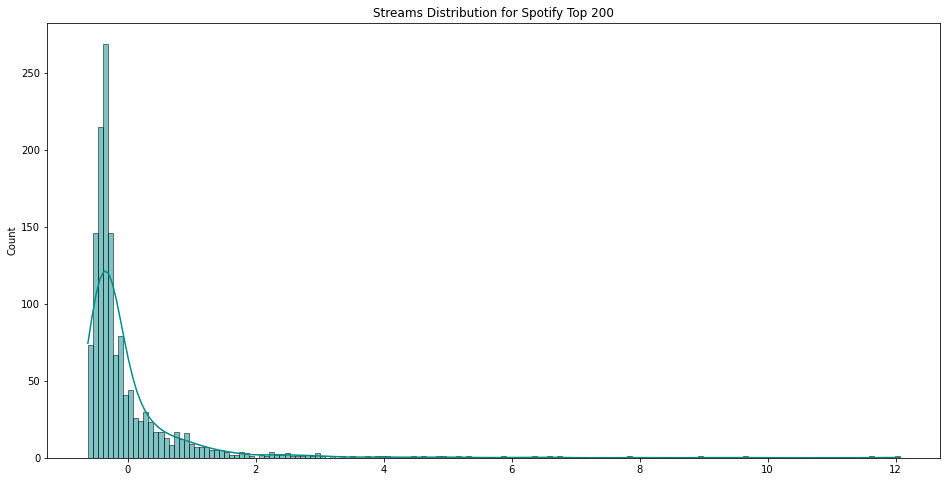

In [126]:
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.histplot(train['Streams'].values, kde=True, color='darkcyan')

ax.set_title('Streams Distribution for Spotify Top 200')
plt.show()

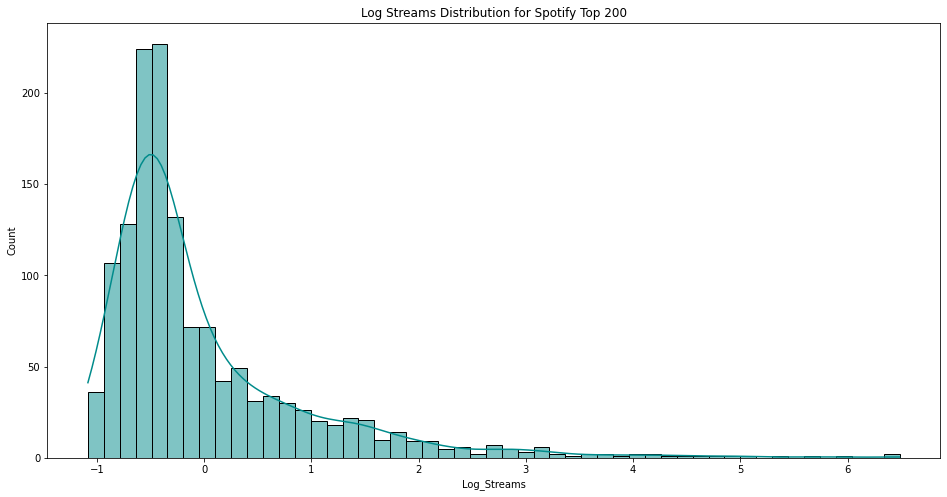

In [127]:
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.histplot(train['Log_Streams'], kde=True, color='darkcyan')

ax.set_title('Log Streams Distribution for Spotify Top 200')
plt.show()

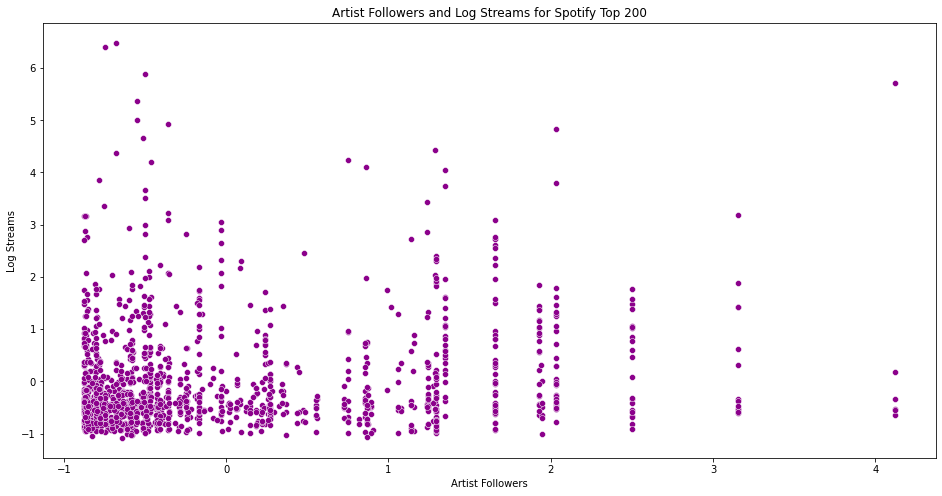

In [128]:
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.scatterplot(x=train['Followers'].values, y=train['Log_Streams'].values, color='darkmagenta')
ax.set(xlabel='Artist Followers', ylabel='Log Streams')
ax.set_title('Artist Followers and Log Streams for Spotify Top 200')
plt.show()

In [129]:
x = train['Followers'].values
y = train['Log_Streams'].values

In [130]:
x

array([-0.86908101,  1.29186262, -0.35882896, ..., -0.64708594,
       -0.49615867,  0.23614803])

In [131]:
y

array([-0.43640344, -0.98470627, -0.16180822, ...,  0.05014312,
       -0.65997462,  0.56804303])

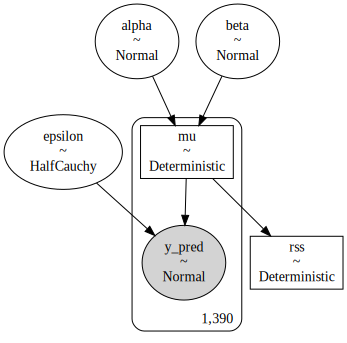

In [22]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    
pm.model_to_graphviz(model)

In [23]:
with model:
    start = pm.find_MAP() 
    step = pm.NUTS()
    trace = pm.sample(10000, tune=2000, step=step, start=start, return_inferencedata=True, random_seed=RANDOM_SEED)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


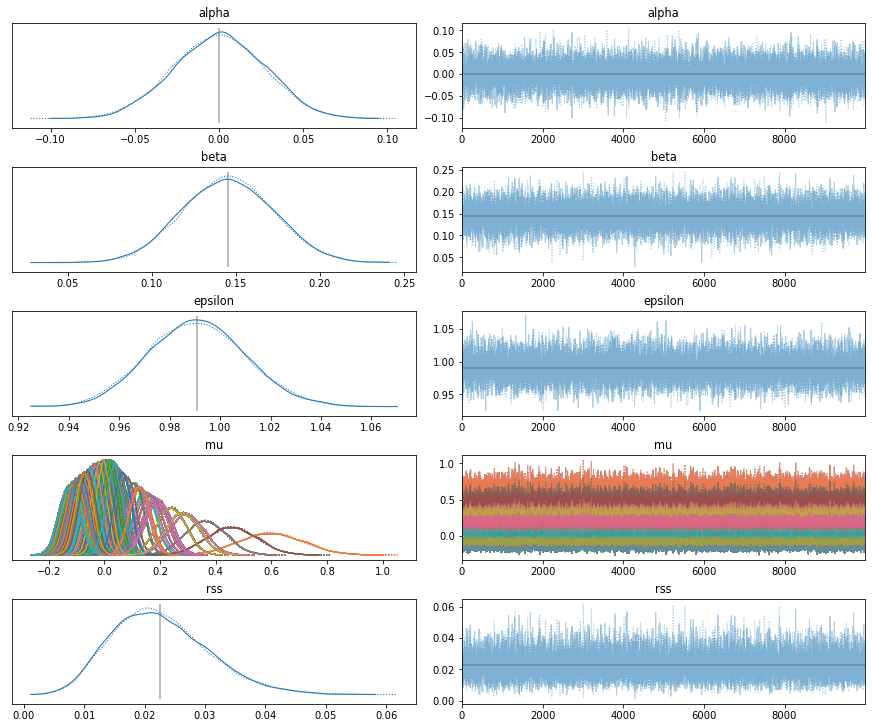

In [24]:
var_names = ['alpha', 'beta', 'epsilon', 'mu', 'rss']
lines = list(xarray_var_iter(trace.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(trace, var_names=var_names, lines=lines);

In [25]:
# az.plot_autocorr(trace, ['alpha', 'beta', 'epsilon']);

In [26]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -0.000  0.027  -0.051    0.050        0.0      0.0   25995.0   
beta      0.145  0.027   0.095    0.196        0.0      0.0   25729.0   
epsilon   0.991  0.019   0.955    1.027        0.0      0.0   24704.0   
mu[0]    -0.126  0.036  -0.195   -0.061        0.0      0.0   26071.0   
mu[1]     0.188  0.044   0.103    0.268        0.0      0.0   25748.0   
...         ...    ...     ...      ...        ...      ...       ...   
mu[1386]  0.188  0.044   0.103    0.268        0.0      0.0   25748.0   
mu[1387] -0.094  0.032  -0.152   -0.032        0.0      0.0   25879.0   
mu[1388] -0.072  0.030  -0.128   -0.015        0.0      0.0   25708.0   
mu[1389]  0.034  0.028  -0.017    0.087        0.0      0.0   26245.0   
rss       0.023  0.008   0.009    0.038        0.0      0.0   24993.0   

          ess_tail  r_hat  
alpha      14735.0    1.0  
beta       14839.0    1.0  
epsilon    13154.0    1.0  
mu[0]      14533.0    1.0  
mu[1]      15336.0    1.0  
...            ...    ...  
mu[1386]   15336.0    1.0  
mu[1387]   14528.0    1.0  
mu[1388]   13811.0    1.0  
mu[1389]   14953.0    1.0  
rss        15517.0    1.0  

[1394 rows x 9 columns]

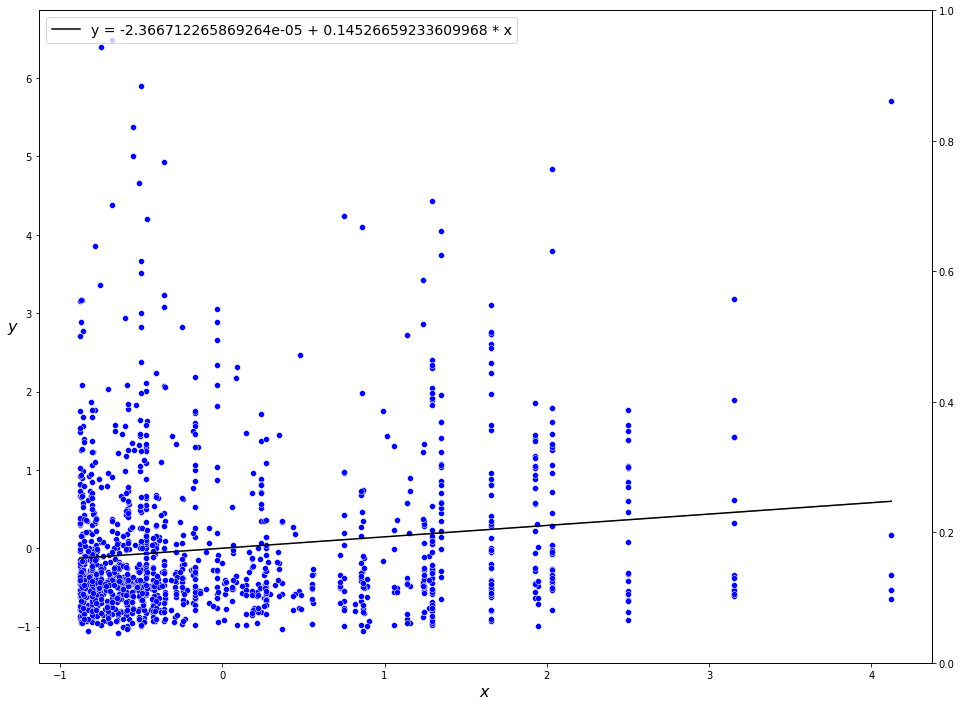

In [27]:
alpha_m = np.array([trace.posterior['alpha'].mean()])
beta_m = np.array([trace.posterior['beta'].mean()])

fig, ax1 = plt.subplots(figsize=(16, 12))
ax1 = sns.scatterplot(x=x, y=y, color='blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = ax1.twiny()
ax2 = sns.lineplot(x=x, y=(alpha_m + beta_m * x), color='black', label=f'y = {alpha_m[0]} + {beta_m[0]} * x', ax=ax2)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16, rotation=0)
ax2.legend(loc=2, fontsize=14)
ax2.set_axis_off()
plt.show()

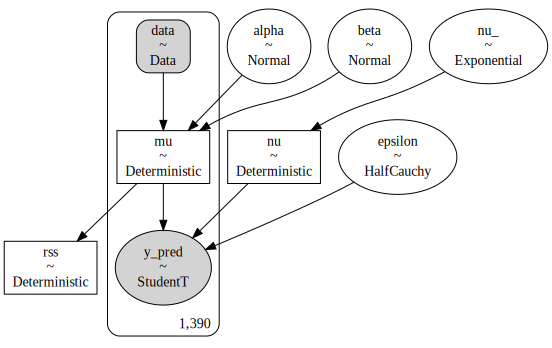

In [28]:
with pm.Model() as model_t:
    data = pm.Data("data", x)
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    mu = pm.Deterministic('mu', alpha + beta * data)
    
    y_pred = pm.StudentT('y_pred', mu=mu, sd=epsilon, nu=nu, observed=y)
    
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    
pm.model_to_graphviz(model_t)

In [29]:
with model_t:
    start = pm.find_MAP() 
    step = pm.NUTS()
    trace_t = pm.sample(10000, tune=2000, step=step, start=start, return_inferencedata=True, random_seed=RANDOM_SEED)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, epsilon, beta, alpha]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 41 seconds.


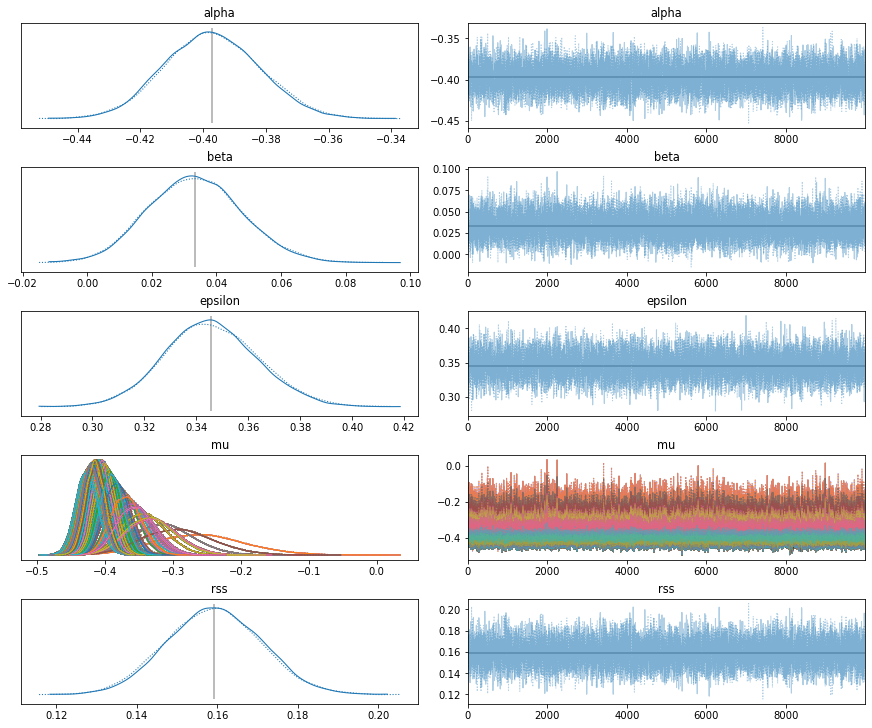

In [30]:
lines3 = list(xarray_var_iter(trace_t.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(trace_t, var_names=var_names, lines=lines3);

In [31]:
az.summary(trace_t)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -0.397  0.015  -0.425   -0.368      0.000    0.000   10677.0   
beta      0.033  0.014   0.007    0.061      0.000    0.000   11193.0   
epsilon   0.346  0.018   0.313    0.380      0.000    0.000    8232.0   
nu_       0.379  0.093   0.214    0.561      0.001    0.001    7928.0   
nu        1.379  0.093   1.214    1.561      0.001    0.001    7928.0   
...         ...    ...     ...      ...        ...      ...       ...   
mu[1386] -0.354  0.027  -0.404   -0.302      0.000    0.000    9141.0   
mu[1387] -0.419  0.015  -0.447   -0.390      0.000    0.000   16484.0   
mu[1388] -0.414  0.015  -0.440   -0.385      0.000    0.000   14909.0   
mu[1389] -0.389  0.017  -0.418   -0.357      0.000    0.000    9722.0   
rss       0.159  0.012   0.137    0.181      0.000    0.000   11225.0   

          ess_tail  r_hat  
alpha      13259.0    1.0  
beta       12295.0    1.0  
epsilon    11119.0    1.0  
nu_         9393.0    1.0  
nu          9393.0    1.0  
...            ...    ...  
mu[1386]   12147.0    1.0  
mu[1387]   14286.0    1.0  
mu[1388]   14515.0    1.0  
mu[1389]   12312.0    1.0  
rss        13880.0    1.0  

[1396 rows x 9 columns]

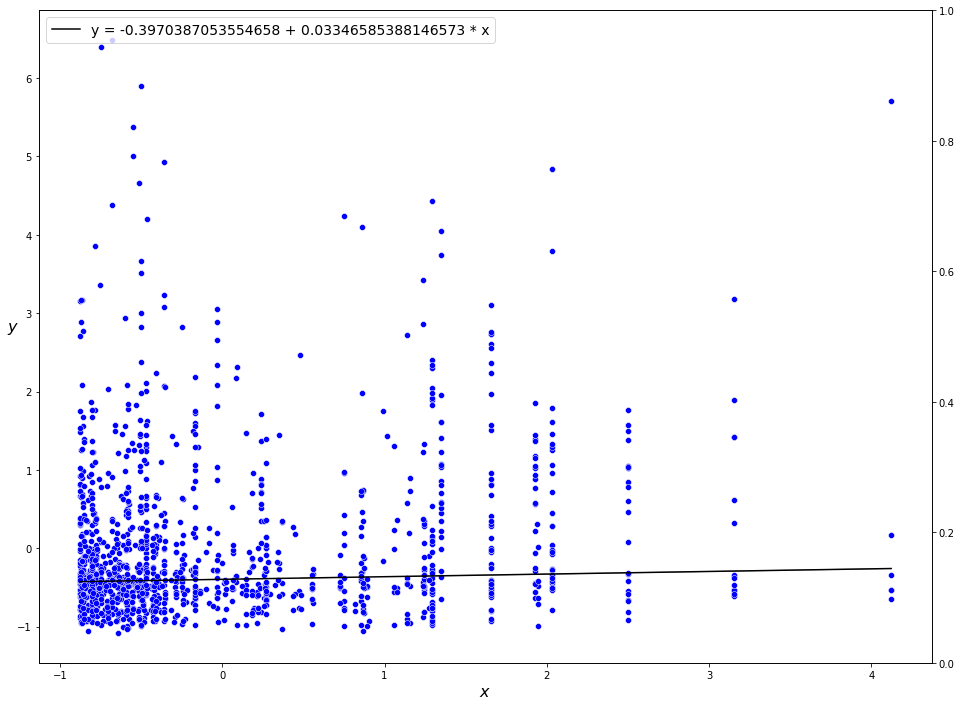

In [32]:
alpha_m_t = np.array([trace_t.posterior['alpha'].mean()])
beta_m_t = np.array([trace_t.posterior['beta'].mean()])

fig, ax1 = plt.subplots(figsize=(16, 12))
ax1 = sns.scatterplot(x=x, y=y, color='blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = ax1.twiny()
ax2 = sns.lineplot(x=x, y=(alpha_m_t + beta_m_t * x), color='black', label=f'y = {alpha_m_t[0]} + {beta_m_t[0]} * x', ax=ax2)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16, rotation=0)
ax2.legend(loc=2, fontsize=14)
ax2.set_axis_off()
plt.show()

In [33]:
with model_t:
    ppc = pm.sample_posterior_predictive(trace_t, random_seed=RANDOM_SEED)

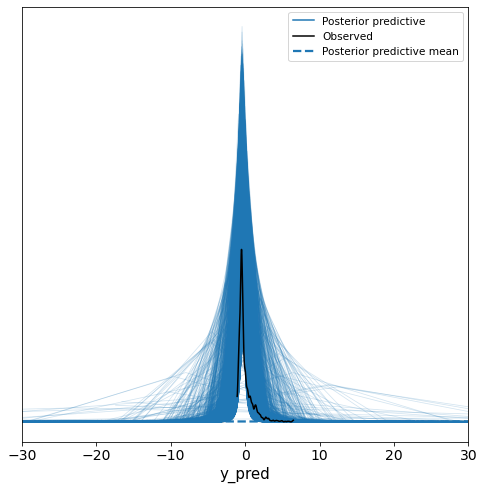

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-30, 30])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_t), ax=ax);

In [35]:
with model_t:
    pm.set_data({"data": test['Followers'].values}, model=model_t)
    ppc_test = pm.sample_posterior_predictive(trace_t, model=model_t, random_seed=RANDOM_SEED)

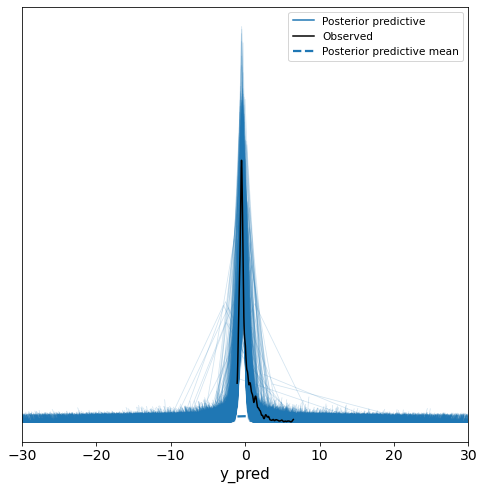

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-30, 30])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_test, model=model_t), ax=ax);

In [37]:
y_pred = ppc_test['y_pred'].mean(axis=0)
mse = sum((test['Log_Streams'].values - y_pred)**2)/len(test['Log_Streams'].values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.6710557105827462


In [38]:
spotify = spotify.reset_index().drop(columns='index')
n_songs = spotify.shape[0]
song_idx = spotify.index.values

C:\Users\anima\AppData\Local\Temp/ipykernel_18940/134256828.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  spotify = spotify.reset_index().drop(columns='index')


In [39]:
len(x), len(y), n_songs, len(song_idx)

(1390, 1390, 1545, 1545)

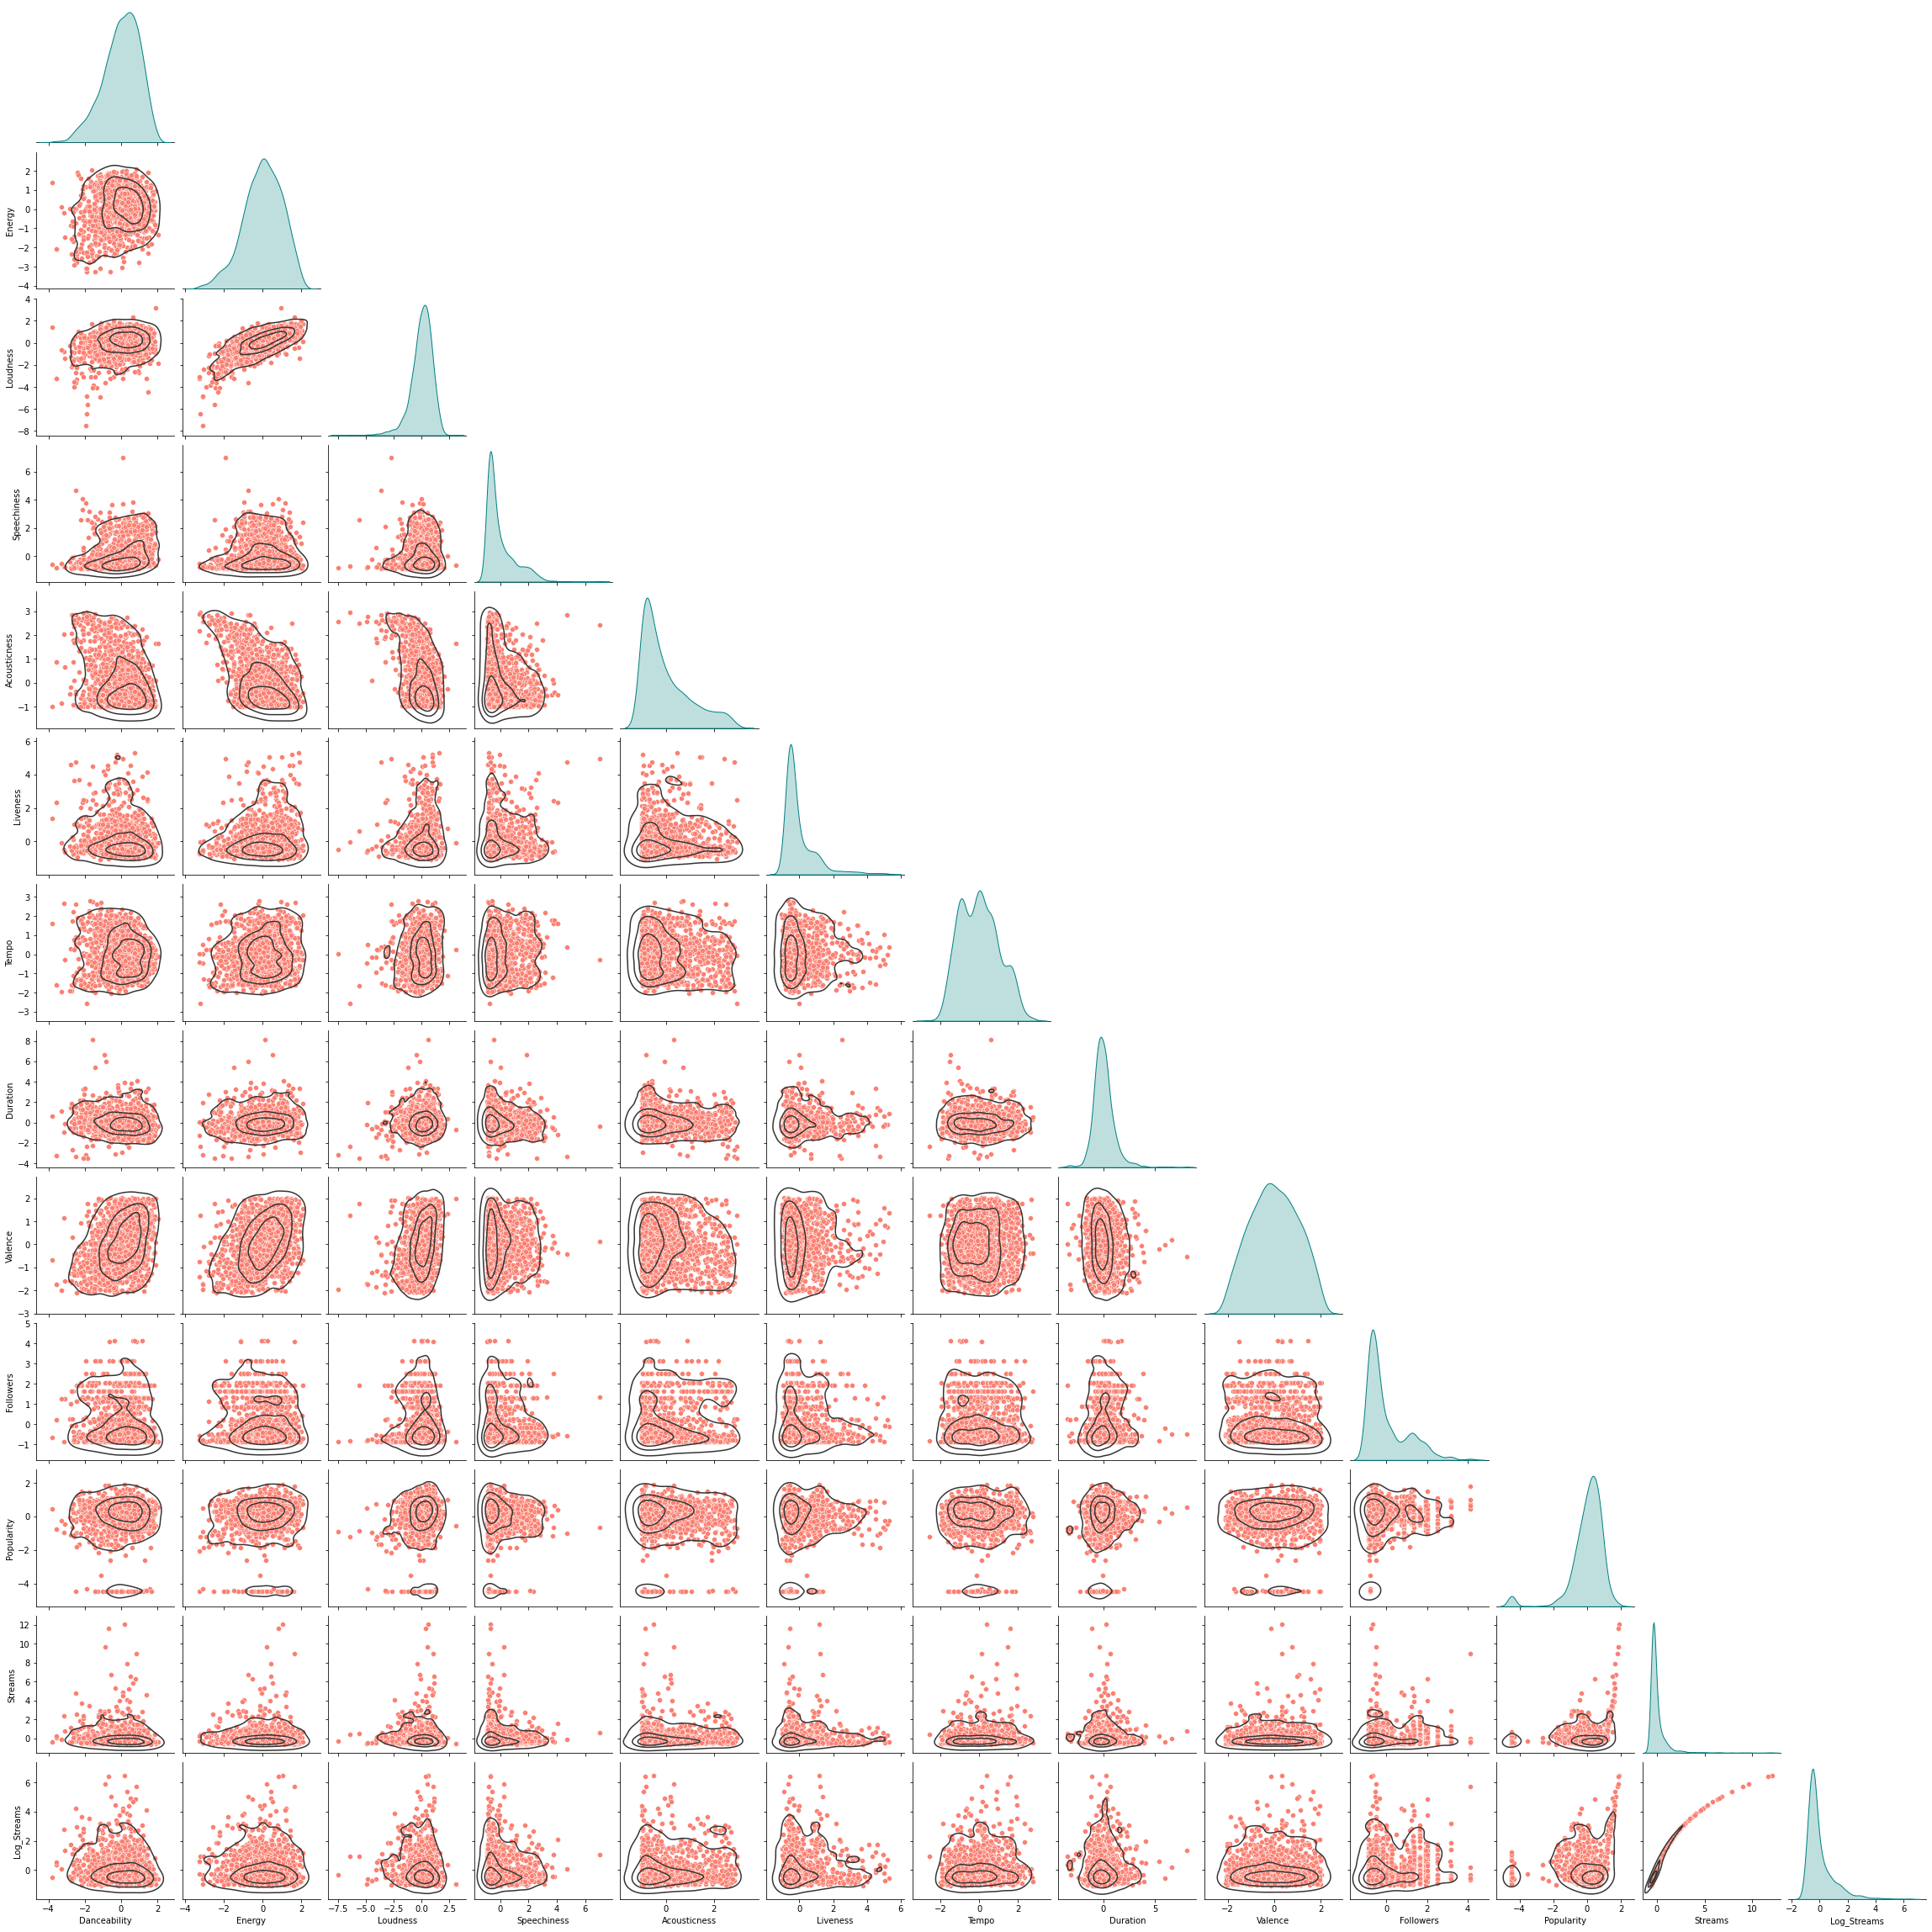

In [40]:
pairplot = sns.pairplot(train[cols], diag_kind='kde', corner=True, plot_kws={'color': '#FA8072'}, diag_kws= {'color': '#008080'});
pairplot.map_lower(sns.kdeplot, levels=4, color=".2");

In [41]:
train.corr(method='pearson')

Danceability    Energy  Loudness  Speechiness  Acousticness  \
Danceability      1.000000  0.143651  0.240254     0.235687     -0.323298   
Energy            0.143651  1.000000  0.726021     0.012553     -0.532471   
Loudness          0.240254  0.726021  1.000000    -0.014184     -0.466545   
Speechiness       0.235687  0.012553 -0.014184     1.000000     -0.131925   
Acousticness     -0.323298 -0.532471 -0.466545    -0.131925      1.000000   
Liveness         -0.114419  0.126170  0.045414     0.040613     -0.007627   
Tempo            -0.046435  0.116795  0.107088     0.097970     -0.067037   
Duration         -0.090130  0.066326  0.079620    -0.089077     -0.054148   
Valence           0.350306  0.362311  0.302142     0.023580     -0.095880   
Followers        -0.100014 -0.064925 -0.033275    -0.067048      0.029630   
Popularity        0.023319  0.096994  0.166918    -0.039109     -0.083078   
Streams          -0.085022  0.005962 -0.028675    -0.066908      0.032448   
Log_Streams      -0.121039 -0.012964 -0.069539    -0.060043      0.059181   

              Liveness     Tempo  Duration   Valence  Followers  Popularity  \
Danceability -0.114419 -0.046435 -0.090130  0.350306  -0.100014    0.023319   
Energy        0.126170  0.116795  0.066326  0.362311  -0.064925    0.096994   
Loudness      0.045414  0.107088  0.079620  0.302142  -0.033275    0.166918   
Speechiness   0.040613  0.097970 -0.089077  0.023580  -0.067048   -0.039109   
Acousticness -0.007627 -0.067037 -0.054148 -0.095880   0.029630   -0.083078   
Liveness      1.000000 -0.026988  0.014850  0.008600  -0.011655   -0.028480   
Tempo        -0.026988  1.000000 -0.014856  0.062958  -0.022411   -0.022938   
Duration      0.014850 -0.014856  1.000000 -0.115066   0.136662    0.085826   
Valence       0.008600  0.062958 -0.115066  1.000000  -0.107556    0.002192   
Followers    -0.011655 -0.022411  0.136662 -0.107556   1.000000    0.099170   
Popularity   -0.028480 -0.022938  0.085826  0.002192   0.099170    1.000000   
Streams       0.041828  0.060760  0.017236  0.039987   0.109663    0.121641   
Log_Streams   0.061170  0.041906  0.023330  0.021577   0.145487    0.062229   

               Streams  Log_Streams  
Danceability -0.085022    -0.121039  
Energy        0.005962    -0.012964  
Loudness     -0.028675    -0.069539  
Speechiness  -0.066908    -0.060043  
Acousticness  0.032448     0.059181  
Liveness      0.041828     0.061170  
Tempo         0.060760     0.041906  
Duration      0.017236     0.023330  
Valence       0.039987     0.021577  
Followers     0.109663     0.145487  
Popularity    0.121641     0.062229  
Streams       1.000000     0.927286  
Log_Streams   0.927286     1.000000

In [132]:
train = train.drop(columns=['Loudness'])
test = test.drop(columns=['Loudness'])

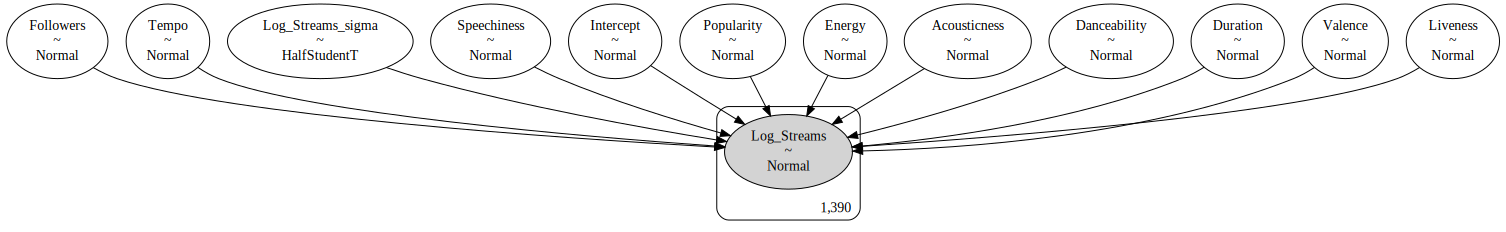

In [52]:
formula = "Log_Streams ~ Danceability + Energy + Speechiness + Acousticness + Liveness + Tempo + Valence + Duration + Followers + Popularity"
model_bmb = bmb.Model(formula, train)
model_bmb.build()
model_bmb.graph(name='multiplereg', figsize=(12,12))

In [53]:
fitted = model_bmb.fit(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Log_Streams_sigma, Intercept, Popularity, Followers, Duration, Valence, Tempo, Liveness, Acousticness, Speechiness, Energy, Danceability]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


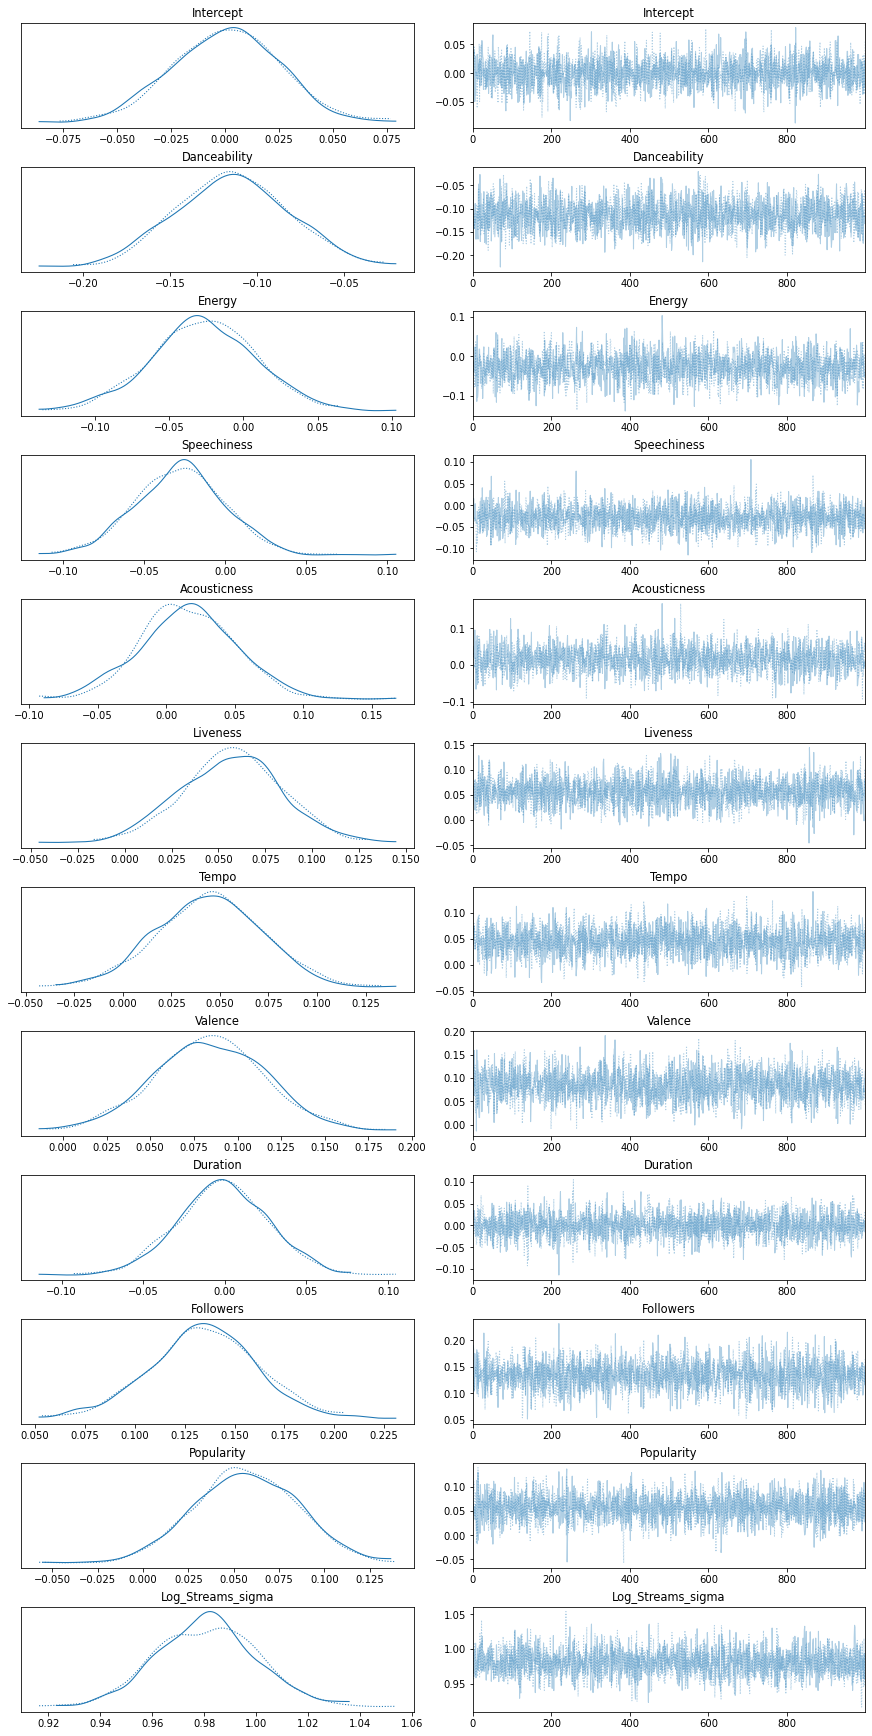

In [54]:
az.plot_trace(fitted);

In [55]:
az.summary(fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.000  0.025  -0.045    0.048      0.000    0.001   
Danceability      -0.114  0.032  -0.173   -0.056      0.001    0.000   
Energy            -0.027  0.035  -0.093    0.039      0.001    0.001   
Speechiness       -0.028  0.027  -0.081    0.021      0.001    0.000   
Acousticness       0.016  0.034  -0.046    0.082      0.001    0.001   
Liveness           0.057  0.027   0.006    0.105      0.001    0.000   
Tempo              0.045  0.027  -0.005    0.096      0.001    0.000   
Valence            0.084  0.032   0.021    0.140      0.001    0.000   
Duration          -0.001  0.027  -0.051    0.051      0.001    0.001   
Followers          0.134  0.027   0.086    0.186      0.001    0.000   
Popularity         0.057  0.028   0.003    0.107      0.001    0.000   
Log_Streams_sigma  0.981  0.019   0.946    1.018      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
Intercept            3141.0    1505.0    1.0  
Danceability         2878.0    1829.0    1.0  
Energy               2083.0    1615.0    1.0  
Speechiness          2993.0    1641.0    1.0  
Acousticness         2160.0    1632.0    1.0  
Liveness             2593.0    1406.0    1.0  
Tempo                2735.0    1611.0    1.0  
Valence              2559.0    1627.0    1.0  
Duration             2664.0    1618.0    1.0  
Followers            2796.0    1771.0    1.0  
Popularity           2743.0    1439.0    1.0  
Log_Streams_sigma    3106.0    1479.0    1.0

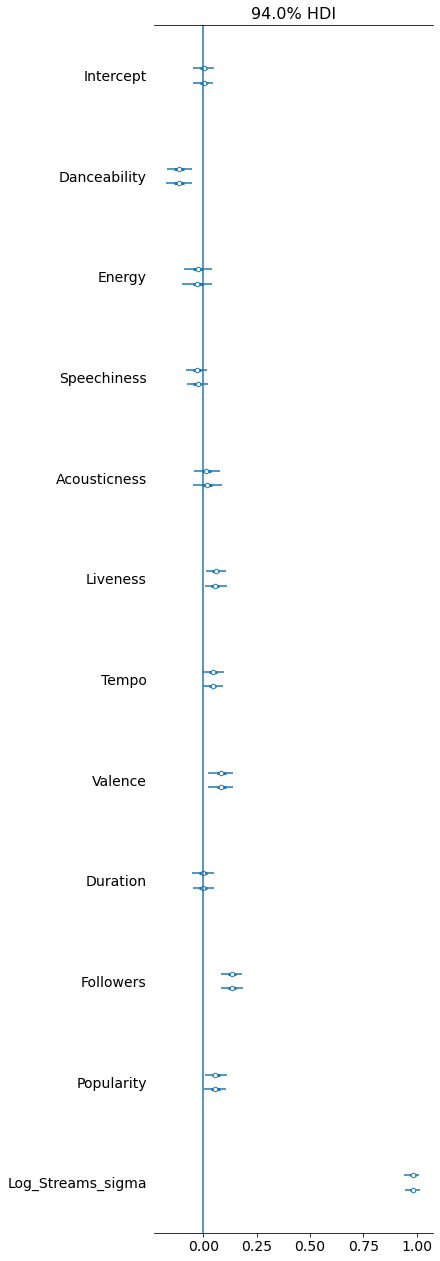

In [56]:
az.plot_forest(fitted);
plt.axvline(0);

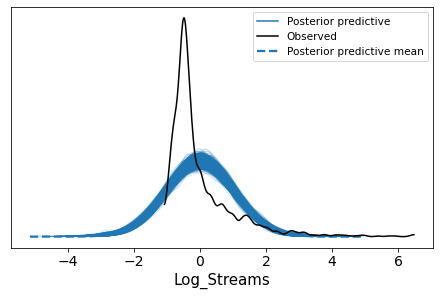

In [57]:
posterior_predictive = model_bmb.predict(fitted, kind="pps")
az.plot_ppc(fitted);

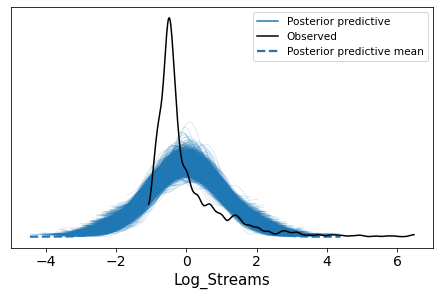

In [69]:
posterior_predictive_ = model_bmb.predict(fitted, kind="pps", data=test.iloc[:, :-2])
az.plot_ppc(fitted);

In [111]:
y_pred = fitted['posterior_predictive']['Log_Streams'].values.mean(axis=0).mean(axis=0)
mse = sum((test['Log_Streams'].values - y_pred)**2)/len(test['Log_Streams'].values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5720862510645325


In [133]:
train.head()

Artist  Danceability    Energy  Speechiness  Acousticness  \
356            Daði Freyr      0.756788 -0.067824    -0.777170     -0.946718   
1083  Bad Bunny, Don Omar      0.574431  1.221584    -0.585652     -0.939158   
1545             Doja Cat     -0.007710 -0.715612    -0.728370      1.038473   
625         Andy Williams     -3.156883 -0.209720    -0.797427      2.045195   
79            Tones And I      0.939146 -0.271414    -0.286406      1.750738   

      Liveness     Tempo  Duration   Valence  Followers  Popularity   Streams  \
356  -0.623013  0.000985 -0.658281 -0.309339  -0.869081   -0.010637 -0.347994   
1083 -0.679708 -0.980094 -0.069544  0.803218   1.291863    0.116825 -0.587589   
1545 -0.142127  0.063107 -0.138022 -1.334294  -0.358829    0.053094 -0.211005   
625  -0.456342  2.657268 -0.951960  1.149249  -0.857054   -0.966604  2.343427   
79   -0.237757 -0.844358  0.248582 -0.002729  -0.710022    0.817867  0.375509   

      Log_Streams  
356     -0.436403  
1083    -0.984706  
1545    -0.161808  
625      2.770960  
79       0.797141

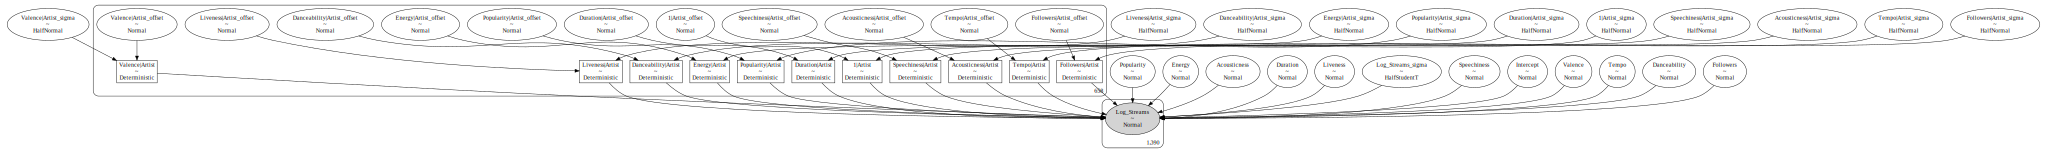

In [134]:
formula_hier = "Log_Streams ~ Danceability + Energy + Speechiness + Acousticness \
                + Liveness + Tempo + Valence + Duration + Followers + Popularity \
                + (Danceability|Artist) + (Energy|Artist) + (Speechiness|Artist) \
                + (Acousticness|Artist) + (Liveness|Artist) + (Tempo|Artist) \
                + (Valence|Artist) + (Duration|Artist) + (Followers|Artist) \
                + (Popularity|Artist)"

priors_hier = {"Intercept": bmb.Prior("Normal", mu=0, sigma=1), 
               "group": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))}

model_bmb_hier = bmb.Model(formula_hier, train, priors=priors_hier)

model_bmb_hier.build()
model_bmb_hier.graph(name='multiplehierreg', figsize=(12,12))

In [135]:
fitted_hier = model_bmb_hier.fit(10000, tune=10000, target_accept=.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Log_Streams_sigma, Popularity|Artist_offset, Popularity|Artist_sigma, Followers|Artist_offset, Followers|Artist_sigma, Duration|Artist_offset, Duration|Artist_sigma, Valence|Artist_offset, Valence|Artist_sigma, Tempo|Artist_offset, Tempo|Artist_sigma, Liveness|Artist_offset, Liveness|Artist_sigma, Acousticness|Artist_offset, Acousticness|Artist_sigma, Speechiness|Artist_offset, Speechiness|Artist_sigma, Energy|Artist_offset, Energy|Artist_sigma, Danceability|Artist_offset, Danceability|Artist_sigma, 1|Artist_offset, 1|Artist_sigma, Intercept, Popularity, Followers, Duration, Valence, Tempo, Liveness, Acousticness, Speechiness, Energy, Danceability]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 1954 seconds.
The number of effective samples is smaller than 25% for some parameters.


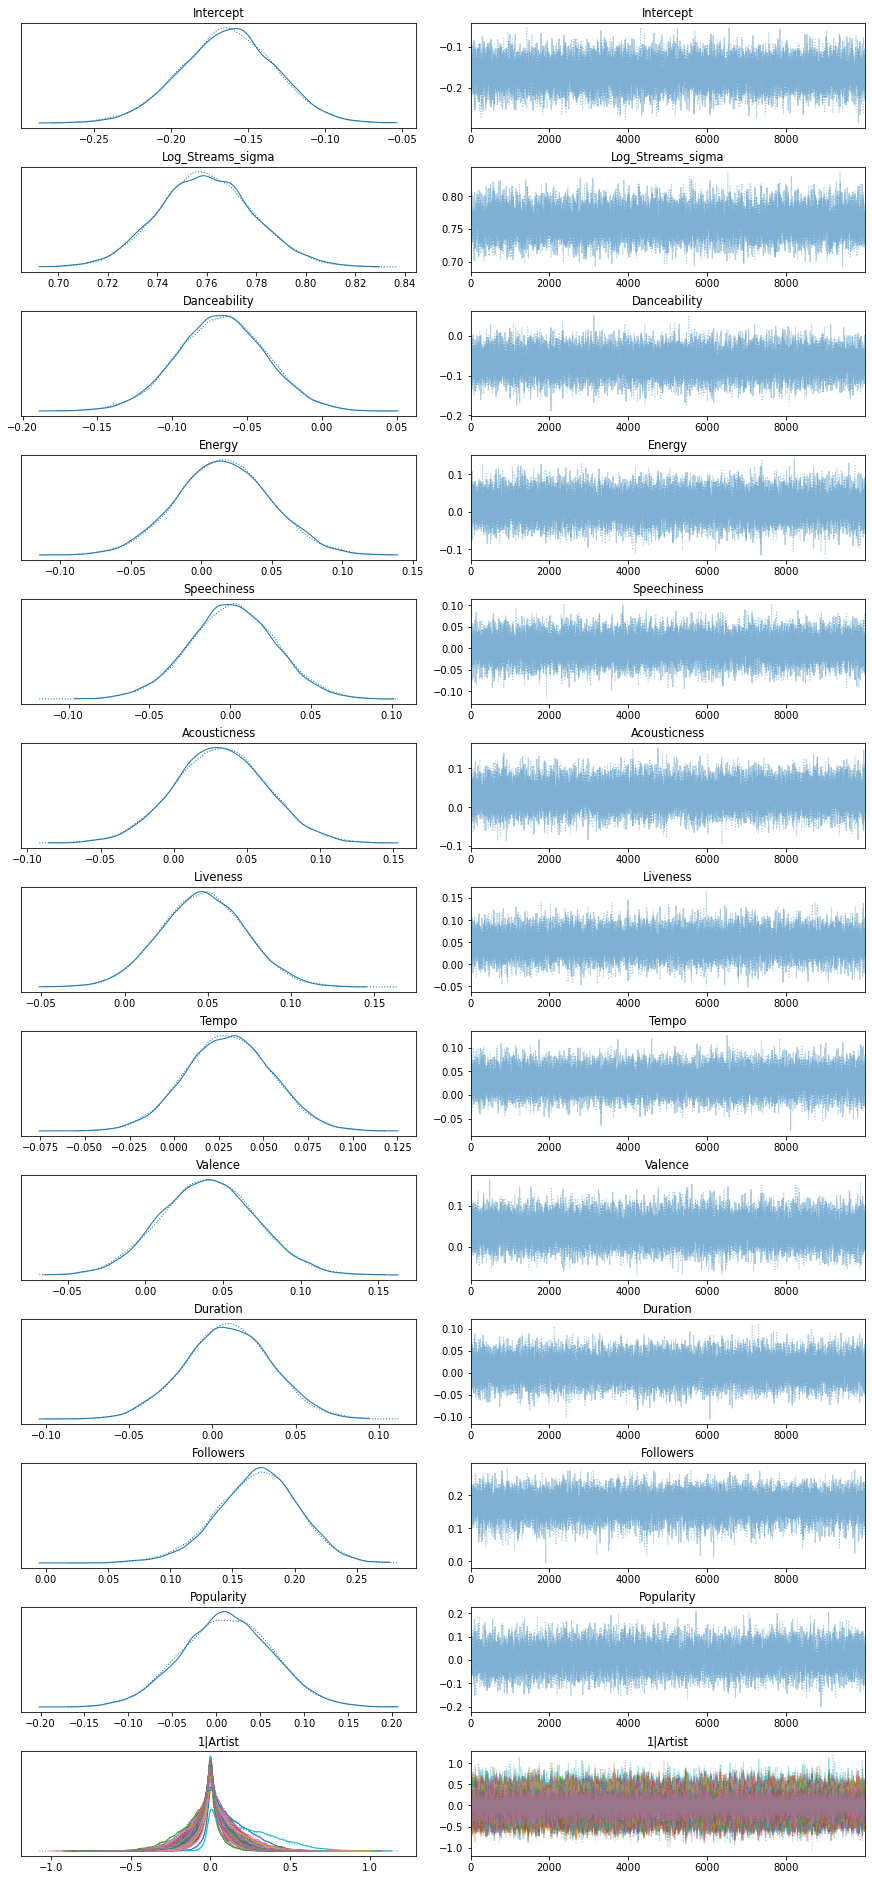

In [143]:
var_names_hier = ['Intercept', 'Log_Streams_sigma', 'Danceability', 'Energy', 'Speechiness', 'Acousticness', 
                  'Liveness', 'Tempo', 'Valence', 'Duration',  'Followers', 'Popularity', '1|Artist']
az.plot_trace(fitted_hier, var_names=var_names_hier);

In [144]:
az.summary(fitted_hier)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              -0.163  0.031  -0.221   -0.106      0.000    0.000   
Danceability           -0.067  0.029  -0.123   -0.012      0.000    0.000   
Energy                  0.015  0.033  -0.047    0.078      0.000    0.000   
Speechiness             0.001  0.027  -0.047    0.054      0.000    0.000   
Acousticness            0.032  0.032  -0.031    0.088      0.000    0.000   
...                       ...    ...     ...      ...        ...      ...   
Popularity|Artist[654] -0.063  0.679  -1.334    1.210      0.003    0.006   
Popularity|Artist[655] -0.032  0.652  -1.297    1.173      0.003    0.005   
Popularity|Artist[656] -0.091  0.577  -1.139    1.025      0.003    0.005   
Popularity|Artist[657] -0.166  0.624  -1.366    0.980      0.003    0.005   
Log_Streams_sigma       0.760  0.019   0.723    0.795      0.000    0.000   

                        ess_bulk  ess_tail  r_hat  
Intercept                17122.0   16084.0    1.0  
Danceability             31399.0   16067.0    1.0  
Energy                   25761.0   16120.0    1.0  
Speechiness              27507.0   15830.0    1.0  
Acousticness             31442.0   17271.0    1.0  
...                          ...       ...    ...  
Popularity|Artist[654]   49634.0   13822.0    1.0  
Popularity|Artist[655]   45909.0   13537.0    1.0  
Popularity|Artist[656]   49359.0   14565.0    1.0  
Popularity|Artist[657]   48702.0   14688.0    1.0  
Log_Streams_sigma         9468.0   13696.0    1.0  

[7261 rows x 9 columns]

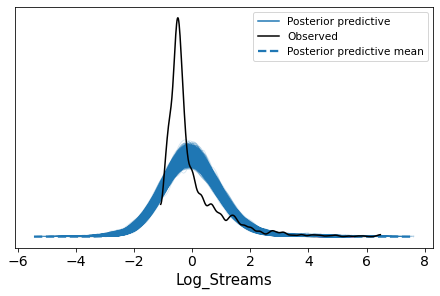

In [145]:
posterior_predictive_hier = model_bmb_hier.predict(fitted_hier, kind="pps")
az.plot_ppc(fitted_hier);

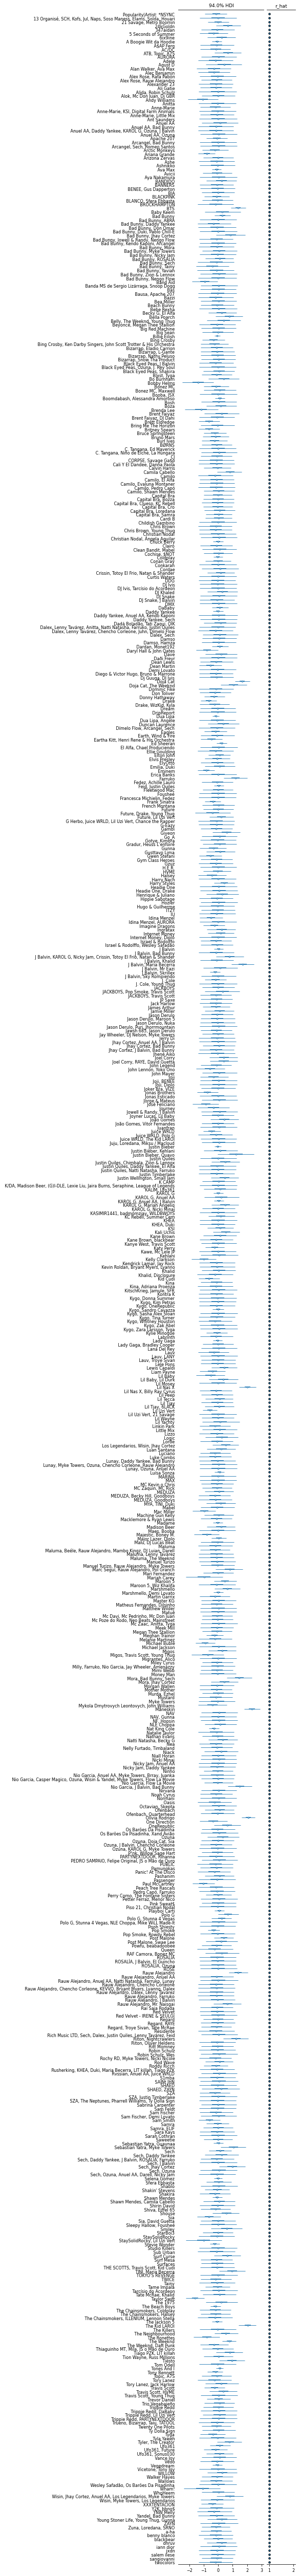

In [161]:
az.plot_forest(fitted_hier, var_names='Popularity|Artist', r_hat=True, combined=True, textsize=8);

In [147]:
# posterior_predictive_hier_ = model_bmb_hier.predict(fitted_hier, kind="pps", data=test.iloc[:, :-2])
# az.plot_ppc(fitted_hier);

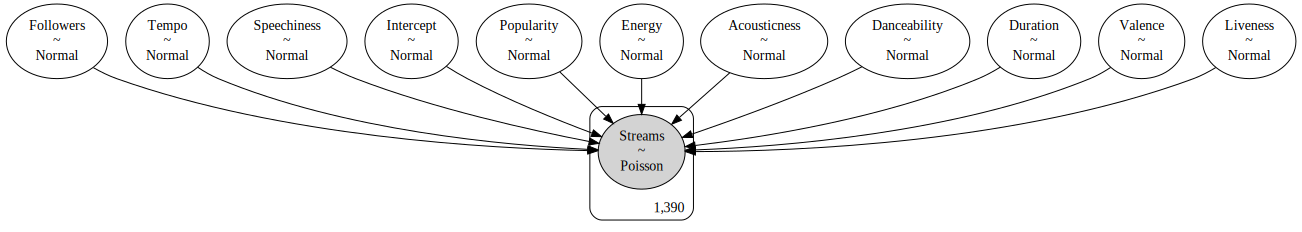

In [162]:
formula_hier_glm = "Streams ~ Danceability + Energy + Speechiness + Acousticness + Liveness + Tempo + Valence + Duration + Followers + Popularity"

mean_hyperprior = bmb.Prior("Normal", mu=0, sigma=10)
prec_hyperprior = bmb.Prior("Gamma", alpha=1, beta=0.1, testval=1.0)

priors_hier_glm = {"Intercept": bmb.Prior("Normal", mu=0, sigma=1),
                   "slope": bmb.Prior("StudentT", mu=mean_hyperprior, lam=prec_hyperprior, nu=1)}

family = "poisson"

model_bmb_hier_glm = bmb.Model(formula_hier_glm, train, priors=priors_hier_glm, family=family)

model_bmb_hier_glm.build()
model_bmb_hier_glm.graph(name='poissonreg', figsize=(12,12))

In [152]:
fitted_hier_glm = model_bmb_hier_glm.fit(10000, tune=10000, target_accept=.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Popularity, Followers, Duration, Valence, Tempo, Liveness, Acousticness, Speechiness, Energy, Danceability]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 150 seconds.


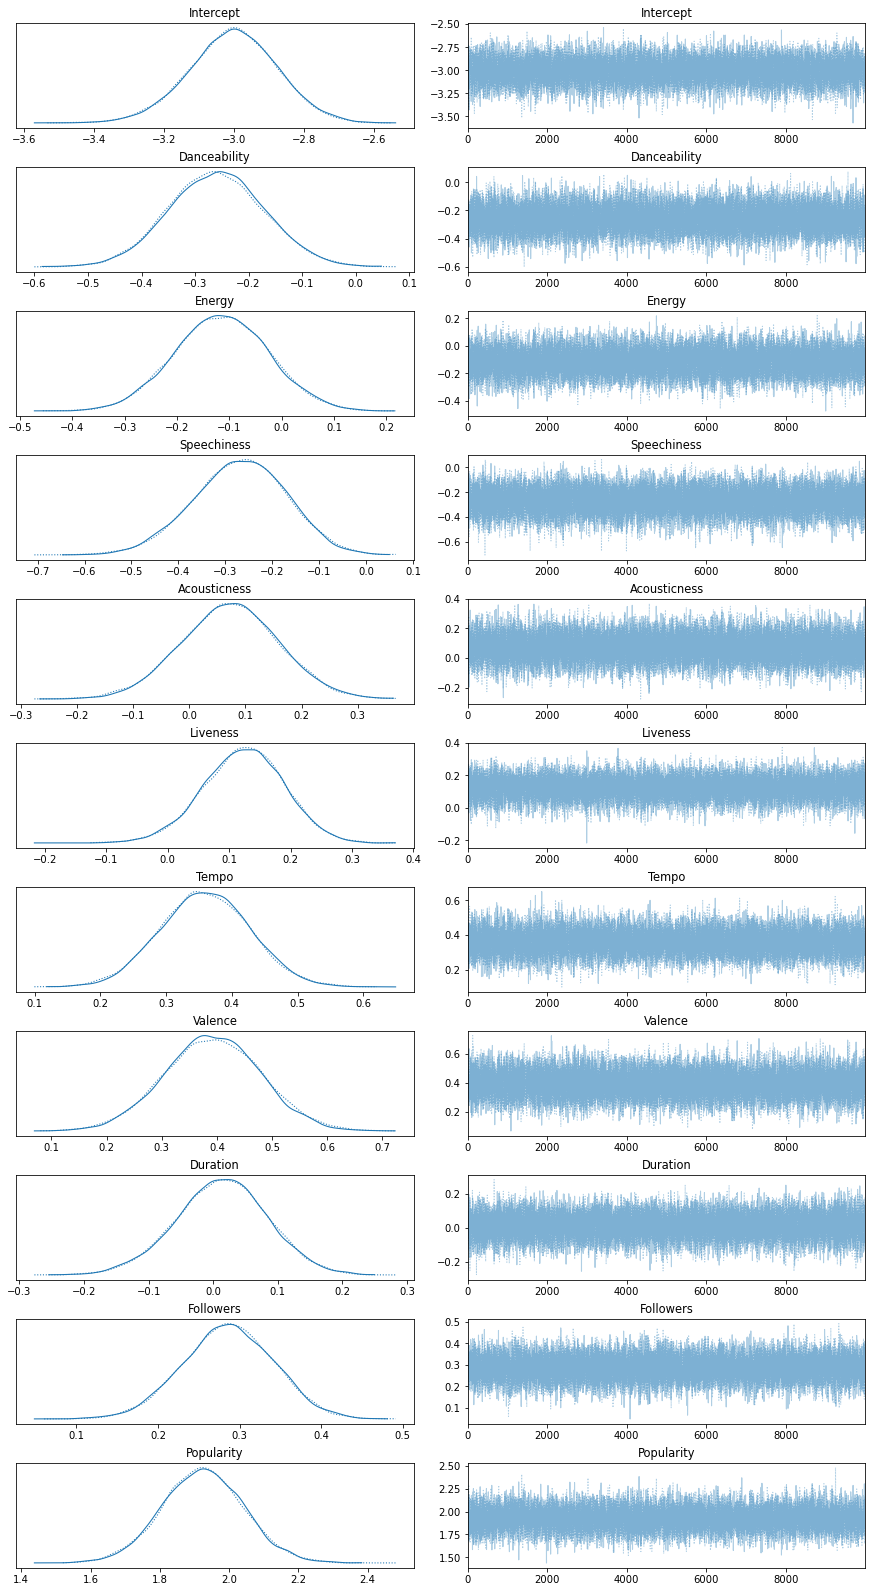

In [153]:
az.plot_trace(fitted_hier_glm);

In [154]:
az.summary(fitted_hier_glm)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -3.004  0.126  -3.245   -2.768      0.001    0.001   18118.0   
Danceability -0.259  0.090  -0.424   -0.087      0.001    0.000   20731.0   
Energy       -0.115  0.089  -0.285    0.050      0.001    0.000   20505.0   
Speechiness  -0.269  0.099  -0.456   -0.086      0.001    0.000   25374.0   
Acousticness  0.073  0.087  -0.087    0.239      0.001    0.000   21944.0   
Liveness      0.123  0.066  -0.005    0.243      0.000    0.000   24583.0   
Tempo         0.359  0.069   0.233    0.489      0.000    0.000   24197.0   
Valence       0.393  0.087   0.231    0.560      0.001    0.000   20762.0   
Duration      0.013  0.071  -0.122    0.146      0.000    0.001   30286.0   
Followers     0.286  0.055   0.182    0.389      0.000    0.000   26202.0   
Popularity    1.924  0.118   1.711    2.159      0.001    0.001   20300.0   

              ess_tail  r_hat  
Intercept      14566.0    1.0  
Danceability   16730.0    1.0  
Energy         15166.0    1.0  
Speechiness    13875.0    1.0  
Acousticness   16710.0    1.0  
Liveness       13352.0    1.0  
Tempo          15023.0    1.0  
Valence        15644.0    1.0  
Duration       15488.0    1.0  
Followers      13823.0    1.0  
Popularity     14685.0    1.0

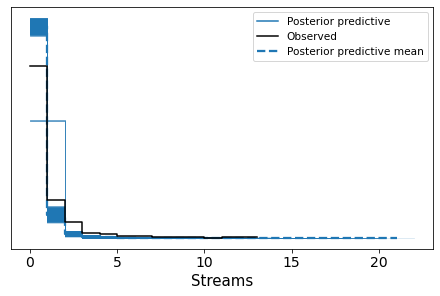

In [157]:
posterior_predictive_hier_glm = model_bmb_hier_glm.predict(fitted_hier_glm, kind="pps")
az.plot_ppc(fitted_hier_glm);

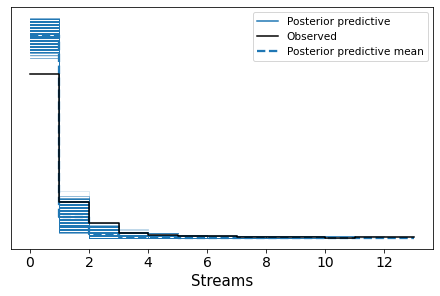

In [158]:
posterior_predictive_hier_glm_ = model_bmb_hier_glm.predict(fitted_hier_glm, kind="pps", data=test.iloc[:, :-2])
az.plot_ppc(fitted_hier_glm);

In [163]:
y_pred = fitted_hier_glm['posterior_predictive']['Streams'].values.mean(axis=0).mean(axis=0)
mse = sum((test['Streams'].values - y_pred)**2)/len(test['Streams'].values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.2989611604295006


In [164]:
models = {"multiple": fitted, "hierarchical": fitted_hier, "generalized": fitted_hier_glm}
df_compare = az.compare(models)
df_compare

C:\Users\anima\anaconda3\envs\bayesian_inference\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\anima\anaconda3\envs\bayesian_inference\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo       p_loo        d_loo    weight         se  \
generalized      0  -588.353946   27.606573     0.000000  0.996016  50.588315   
hierarchical     1 -1801.668684  322.965365  1213.314739  0.000584  52.962477   
multiple         2 -1953.317587   16.528550  1364.963641  0.003400  57.256470   

                    dse  warning loo_scale  
generalized    0.000000    False       log  
hierarchical  38.961190     True       log  
multiple      38.694513    False       log

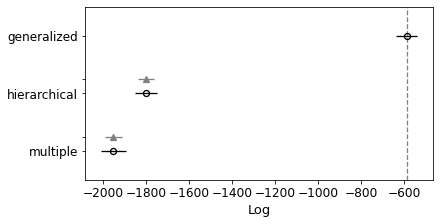

In [165]:
az.plot_compare(df_compare, insample_dev=False);